# Лабораторная работа 6

По имеющемуся образцу создайте разреженное представление функции f(t) = cos(10wt + 30) + 2cos(750wt) + sin(150wt). Здесь w - "омега" = 2*pi. Какое количество отсчетов потребовалось для решения задачи?

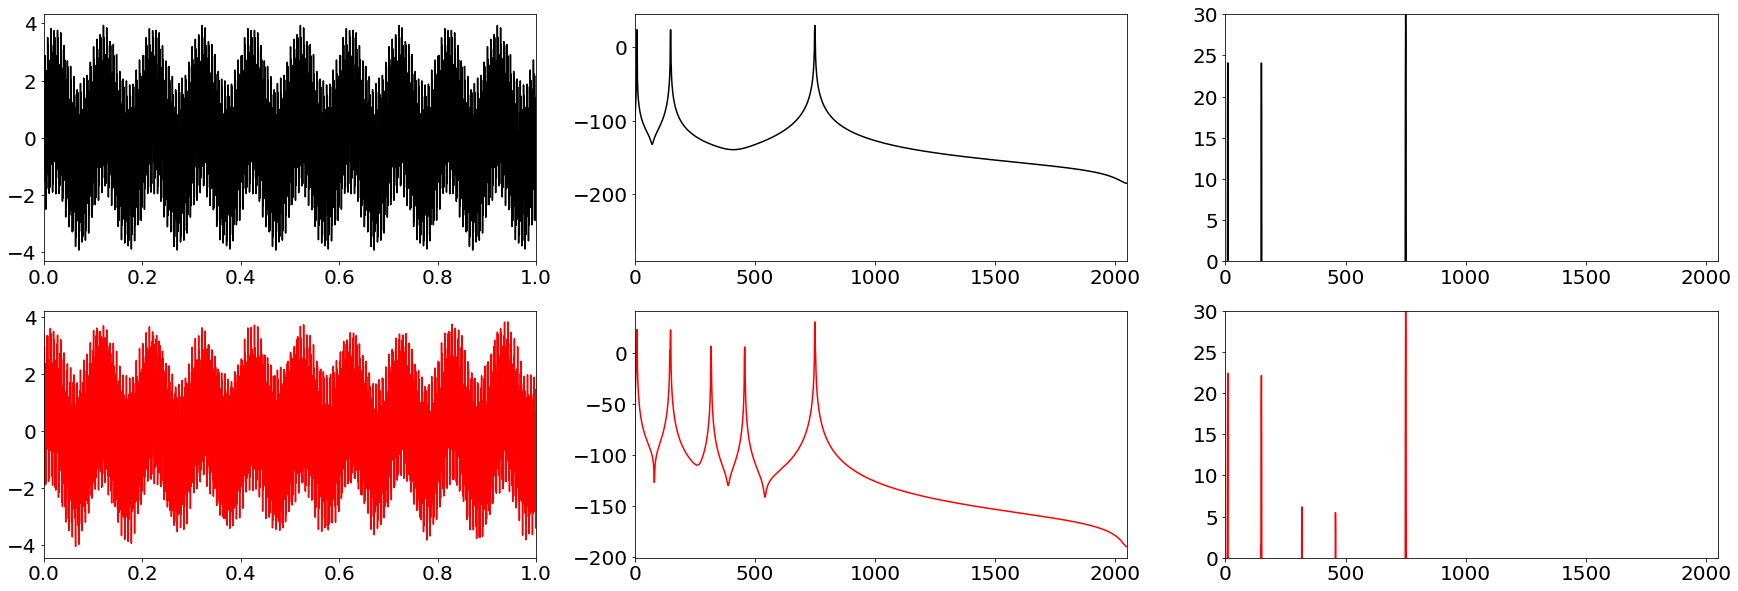

Коэффициент Пирсона оригинальной и восстановленной последовательностей: 0.9710
Количество отсчетов: 256 из 4096


In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
from scipy.fftpack import dst, idst
from scipy.fftpack import fft, ifft

def cosamp(phi, u, s, epsilon=1e-10, max_iter=1000):
    """
    Return an `s`-sparse approximation of the target signal
    Input:
        - phi, sampling matrix
        - u, noisy sample vector
        - s, sparsity
    """
    a = np.zeros(phi.shape[1])
    v = u
    it = 0 # count
    halt = False
    while not halt:
        it += 1
        print("Iteration {}\r".format(it), end="")
        
        y = np.dot(np.transpose(phi), v)
        omega = np.argsort(y)[-(2*s):] # large components
        omega = np.union1d(omega, a.nonzero()[0]) # use set instead?
        phiT = phi[:, omega]
        b = np.zeros(phi.shape[1])
        # Solve Least Square
        b[omega], _, _, _ = np.linalg.lstsq(phiT, u, rcond=None)
        
        # Get new estimate
        b[np.argsort(b)[:-s]] = 0
        a = b
        
        # Halt criterion
        v_old = v
        v = u - np.dot(phi, a)

        halt = (np.linalg.norm(v - v_old) < epsilon) or \
            np.linalg.norm(v) < epsilon or \
            it > max_iter
        
    return a

## Генерация сигнала, выполнение Фурье преобразования
n = 4096 # точки отсчетов для высокого разрешения
t = np.linspace(0,1,n)
x = np.cos(2*np.pi*10*t + 30) + 2*np.cos(2*np.pi*750*t) + np.sin(2*np.pi*150*t)
xt = fft(x*np.hanning(len(x))) # Получение Фурье-образа функции
PSD = np.real(xt * np.conj(xt) / n) # Расчет спектральной плотности мощности

## Взятие рандомных отсчетов из сигнала
p = 256 # число случайных (сжатых) измерений
perm = np.floor(np.random.rand(p) * n).astype(int) # формирование массива индексов для случайной выборки отсчетов
y = x[perm] # массив значений функции из выбранных случайным образом отсчетов - "сжатое измерение"

## Восстановление сигнала из ограниченного числа отсчетов
Psi = dst(np.identity(n)) + dct(np.identity(n))# создание матрицы "Пси"
Theta = Psi[perm,:]       # Значения функции для соответствующих строк матрицы "Пси"

s = cosamp(Theta,y,10,epsilon=1.e-10,max_iter=10) # Получение разреженного вектора s через CoSaMP

xrecon = idst(s) + idct(s)# Реконструкция сигнала на основе случайных выборок

xtrecon = fft(xrecon*np.hanning(len(xrecon)),n) # расчет Фурье-образа для восстановленного сигнала
PSDrecon = np.real(xtrecon * np.conj(xtrecon) / n) # Расчет СПМ для восстановленного сигнала

## Построение графиков
freq = np.arange(n)
L = int(np.floor(n/2))

plt.rcParams.update({'font.size': 20})
                    
fig,axs = plt.subplots(2,3, figsize=(30, 10))
axs = axs.reshape(-1)

axs[0].plot(t,x,color='k') # исходный сигнал во временной области
axs[0].set_xlim(0, 1)

axs[1].plot(freq[:L],10*np.log10(PSD[:L]),color='k') # СПМ исходного сигнала
axs[1].set_xlim(0, n/2)

axs[2].plot(freq[:L],10*np.log10(PSD[:L]),color='k') # приближенная СПМ исходного сигнала
axs[2].set_xlim(0, n/2)
axs[2].set_ylim(0, 30)

axs[3].plot(t,xrecon,color='r') # сигнал, восстановленный по случайным отсчетам во временной области
axs[3].set_xlim(0, 1)

axs[4].plot(freq[:L],10*np.log10(PSDrecon[:L]),color='r') # СПМ восстановленного сигнала
axs[4].set_xlim(0, n/2)

axs[5].plot(freq[:L],10*np.log10(PSDrecon[:L]),color='r') # приближенная СПМ восстановленного сигнала
axs[5].set_xlim(0, n/2)
axs[5].set_ylim(0, 30)

plt.show()

print("Коэффициент Пирсона оригинальной и восстановленной последовательностей: %.4f"%np.corrcoef(x, xrecon)[0, 1])
print("Количество отсчетов: %d из %d"%(p,n))